### 测试使用新的文本模态特征抽取和融合算法计算得到的`idcor`值是否合理

In [1]:
import torch
from tqdm import tqdm
from utils.metrics import id_correlation
from utils.intrinsic_dimension import estimate_id
import logging
from dataclasses import dataclass
from typing import List, Dict, Any, Tuple

# 绘图库
from matplotlib import pyplot as plt
import numpy as np

from analyze_statistics.analyzeMMRep import analyze_corr_rep, draw_corr_columnar_distribution, correlation_compute

In [2]:
id_alg = 'twoNN'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s %(levelname)s [%(name)s] %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)

#### 载入`tranjson_ck2000_qwen2.5_3B_Instruct_clipvL14_model`并计算抽取的`text_embeds`和`image_embeds`每个batch的corr

In [3]:
textRepPath = './representation/LLaVA-CC3M-Pretrain-595K/v2/trainjson_ck2000_qwen2.5_3B_Instruct_clipvL14_model_text.pt'
imageRepPath = './representation/LLaVA-CC3M-Pretrain-595K/v2/trainjson_ck2000_qwen2.5_3B_Instruct_clipvL14_model_image.pt'
text_reps = torch.load(textRepPath)
image_reps = torch.load(imageRepPath)

In [4]:
batch_size = 256
# 使用 torch.split 分割张量
text_reps_batches = torch.split(text_reps, batch_size)
image_reps_batches = torch.split(image_reps, batch_size)

In [5]:
text_id_list = []
image_id_list = []
idcor_list = []
p_list = []
merge_id_list = []

# 以batch_size为一批的大小，计算text_embeds与image_embeds之间的corr
for batch, (text_embeds, image_embeds) in tqdm(enumerate(zip(text_reps_batches, image_reps_batches))):
    corr = id_correlation(text_embeds.to(torch.float32), image_embeds.to(torch.float32), 100, id_alg)
    text_id_list.append(corr['id1'])
    image_id_list.append(corr['id2'])
    idcor_list.append(corr['corr'])
    p_list.append(corr['p'])
    merge_id_list.append(corr['id'])

2326it [07:45,  4.99it/s]


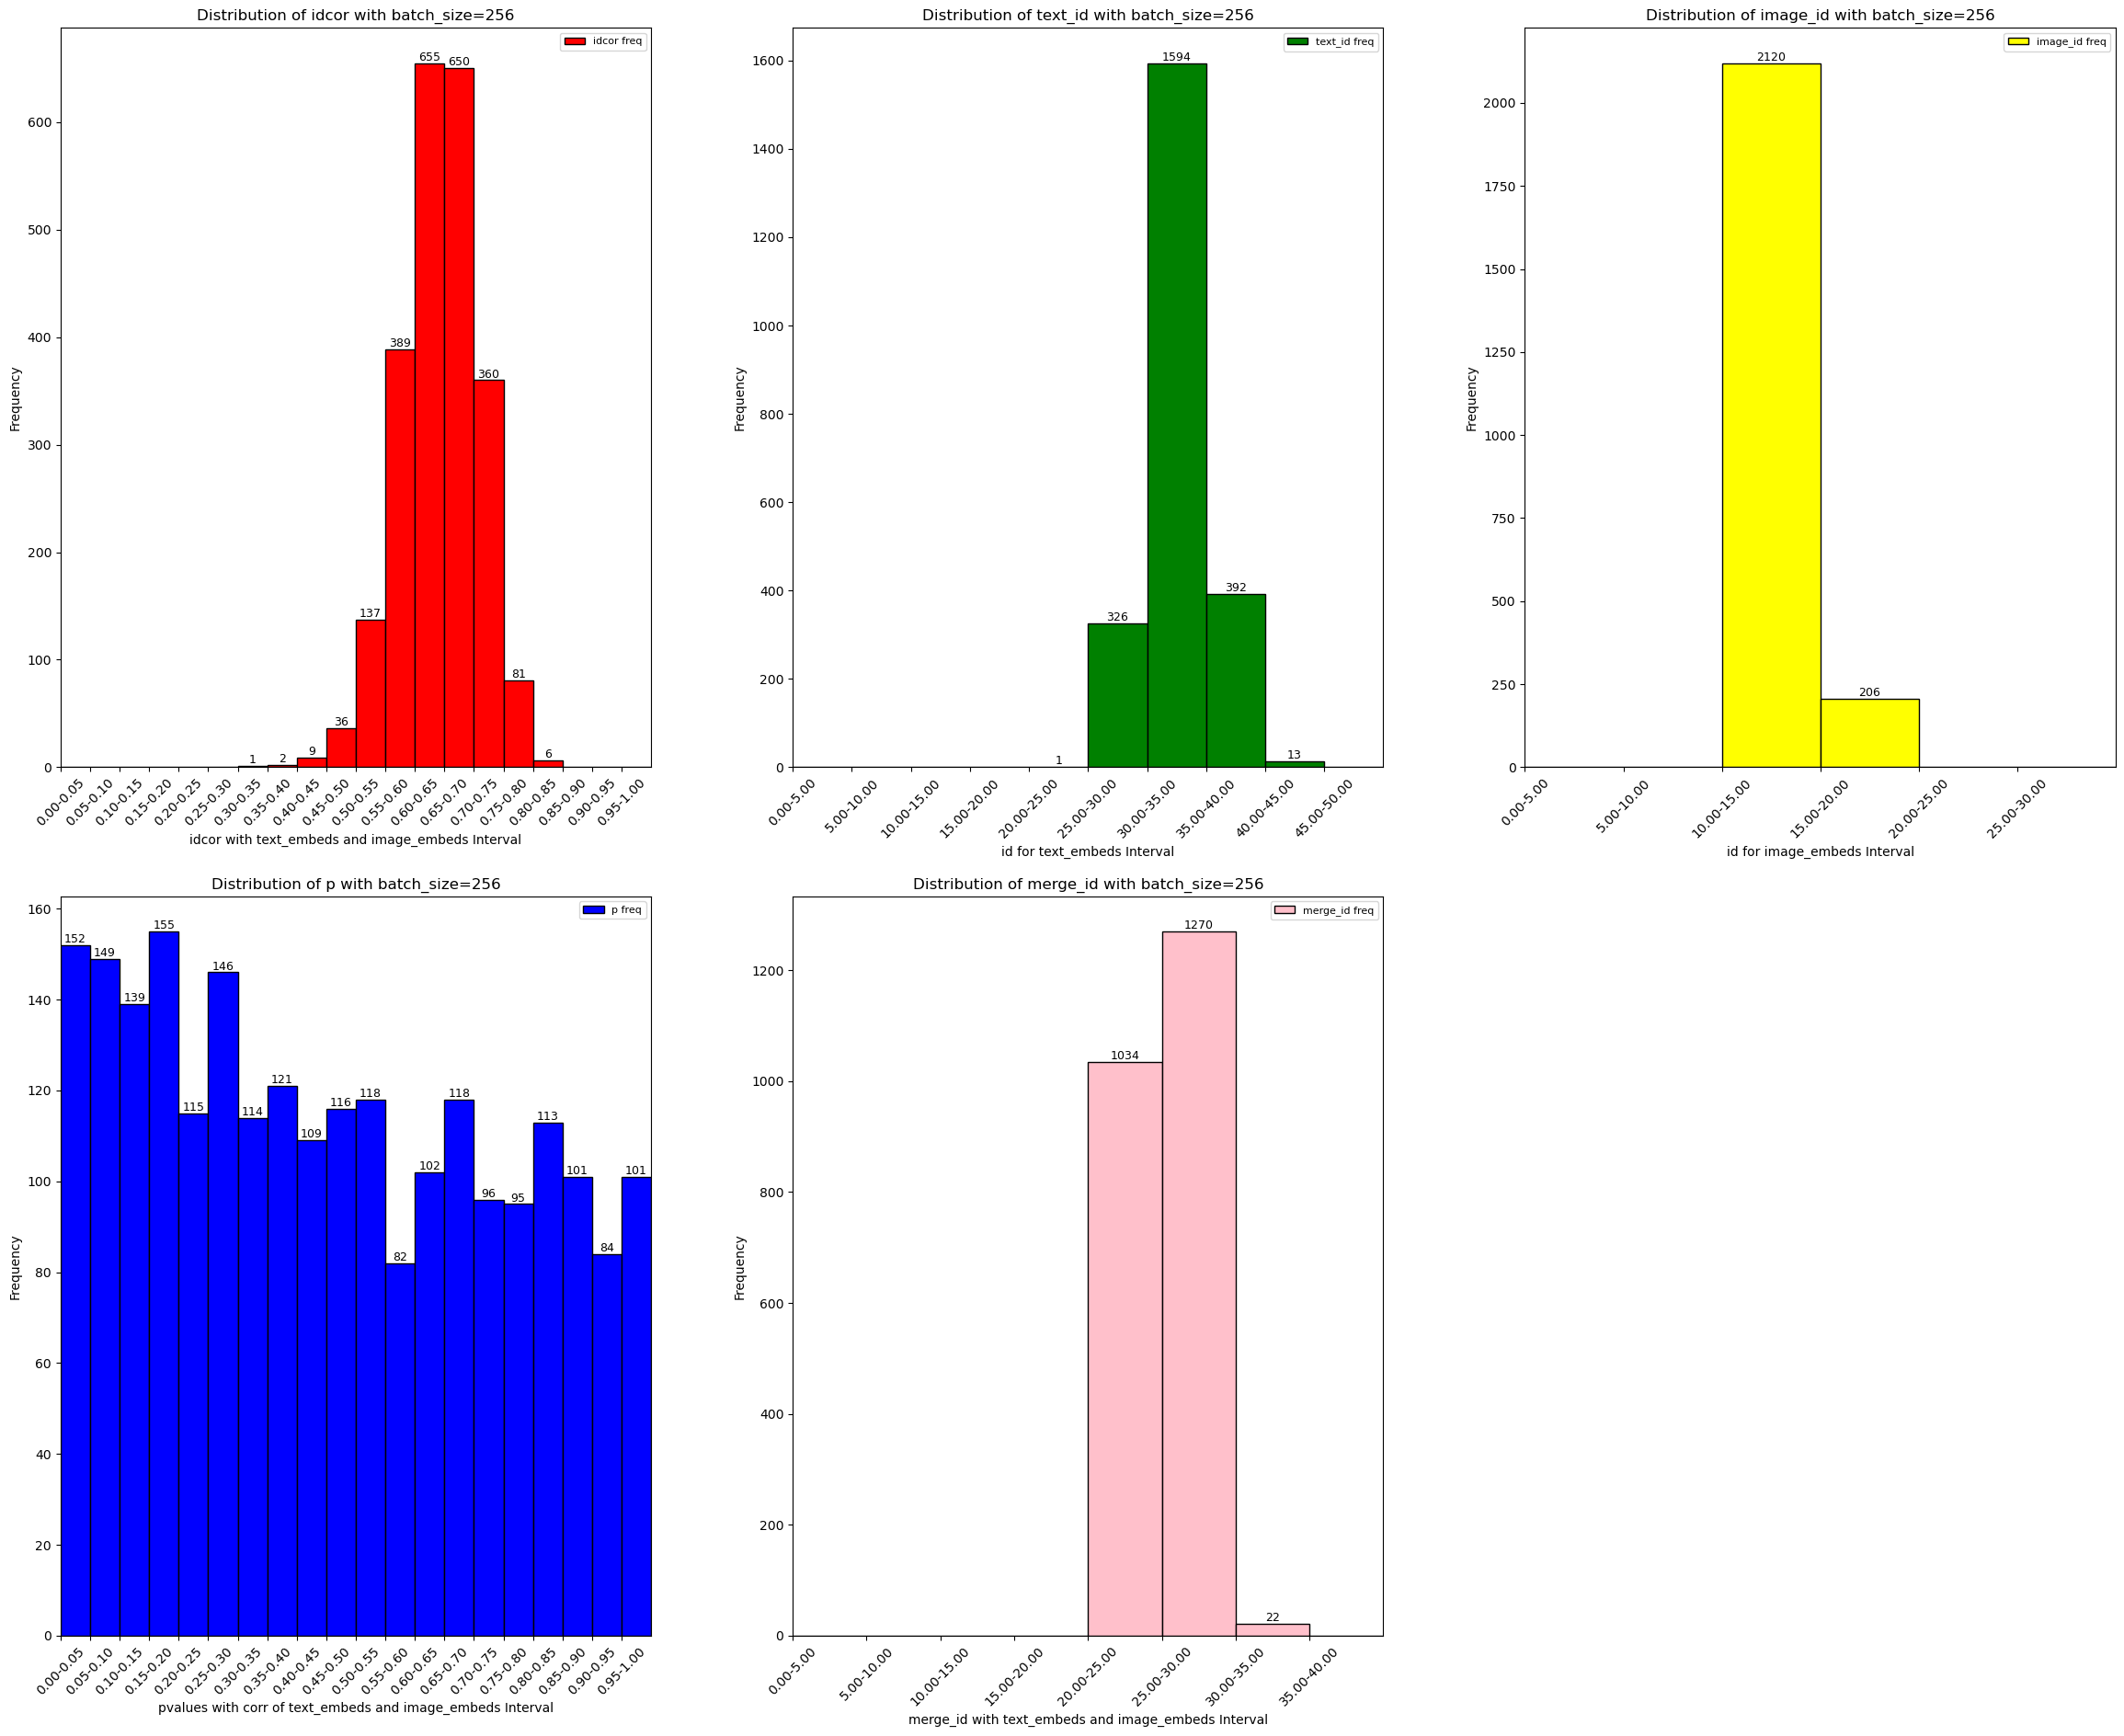

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(25, 20))  # 创建一个包含 2 行 3 列子图的图形
fig.tight_layout(pad=8.0)  # 子图之间的间距

bin_start_list = [0.0, 0.0, 0.0, 0.0, 0.0]
bin_end_list = [1.0, 50.0, 30.0 ,1.0, 40.0]
bin_width_list = [0.05, 5.0, 5.0, 0.05, 5.0]
data_list = [idcor_list, text_id_list, image_id_list, p_list, merge_id_list]
name_list = ['idcor', 'text_id', 'image_id', 'p', 'merge_id']
color_list = ['red', 'green', 'yellow', 'blue', 'pink']
xlabel_list = [
    'idcor with text_embeds and image_embeds Interval',
    'id for text_embeds Interval',
    'id for image_embeds Interval',
    'pvalues with corr of text_embeds and image_embeds Interval',
    'merge_id with text_embeds and image_embeds Interval'
]

for i, ax in enumerate(axs.flat):  # axs.flat 会将二维子图展平，便于迭代
    if i < len(data_list):
        bins = np.arange(bin_start_list[i], bin_end_list[i] + bin_width_list[i], bin_width_list[i])  # 使用numpy的histogram函数来分割数据
        hist, bin_edges = np.histogram(data_list[i], bins=bins)
        
        # 绘制柱状图
        ax.bar(bin_edges[:-1], hist, width=bin_width_list[i], align='edge', edgecolor='black', color=color_list[i])
        
        # 设置标签
        ax.set_xlabel(xlabel_list[i])
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {name_list[i]} with batch_size={batch_size}')
        
        xScale = [f'{bin_edges[j]:.2f}-{bin_edges[j+1]:.2f}' for j in range(len(bin_edges)-1)]  # 设置x轴刻度
        ax.set_xticks(bin_edges[:-1])
        ax.set_xticklabels(xScale, rotation=45)  # 将标签旋转45度，防止重叠
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
        
        # 在每个柱子上方显示频率数值
        for j in range(len(hist)):
            if hist[j] > 0:  # 只对频率大于0的柱子标识
                ax.text(bin_edges[j] + bin_width_list[i] / 2, hist[j], str(hist[j]), ha='center', va='bottom', fontsize=9, color='black')
        
        ax.legend([f'{name_list[i]} freq'], loc='upper right', fontsize=8)  # 添加图例

fig.delaxes(axs[1, 2])  # 删除右下角的空白子图
plt.show()

#### 载入`tranjson_ck4000_qwen2.5_3B_Instruct_clipvL14_model`并计算抽取的`text_embeds`和`image_embeds`每个batch的corr

In [3]:
textRepPath = './representation/LLaVA-CC3M-Pretrain-595K/v2/trainjson_ck4000_qwen2.5_3B_Instruct_clipvL14_model_text.pt'
imageRepPath = './representation/LLaVA-CC3M-Pretrain-595K/v2/trainjson_ck4000_qwen2.5_3B_Instruct_clipvL14_model_image.pt'
text_reps = torch.load(textRepPath)
image_reps = torch.load(imageRepPath)

In [4]:
batch_size = 256
# 使用 torch.split 分割张量
text_reps_batches = torch.split(text_reps, batch_size)
image_reps_batches = torch.split(image_reps, batch_size)

In [5]:
text_id_list = []
image_id_list = []
idcor_list = []
p_list = []
merge_id_list = []

# 以batch_size为一批的大小，计算text_embeds与image_embeds之间的corr
for batch, (text_embeds, image_embeds) in tqdm(enumerate(zip(text_reps_batches, image_reps_batches))):
    corr = id_correlation(text_embeds.to(torch.float32), image_embeds.to(torch.float32), 100, id_alg)
    text_id_list.append(corr['id1'])
    image_id_list.append(corr['id2'])
    idcor_list.append(corr['corr'])
    p_list.append(corr['p'])
    merge_id_list.append(corr['id'])

2326it [08:02,  4.82it/s]


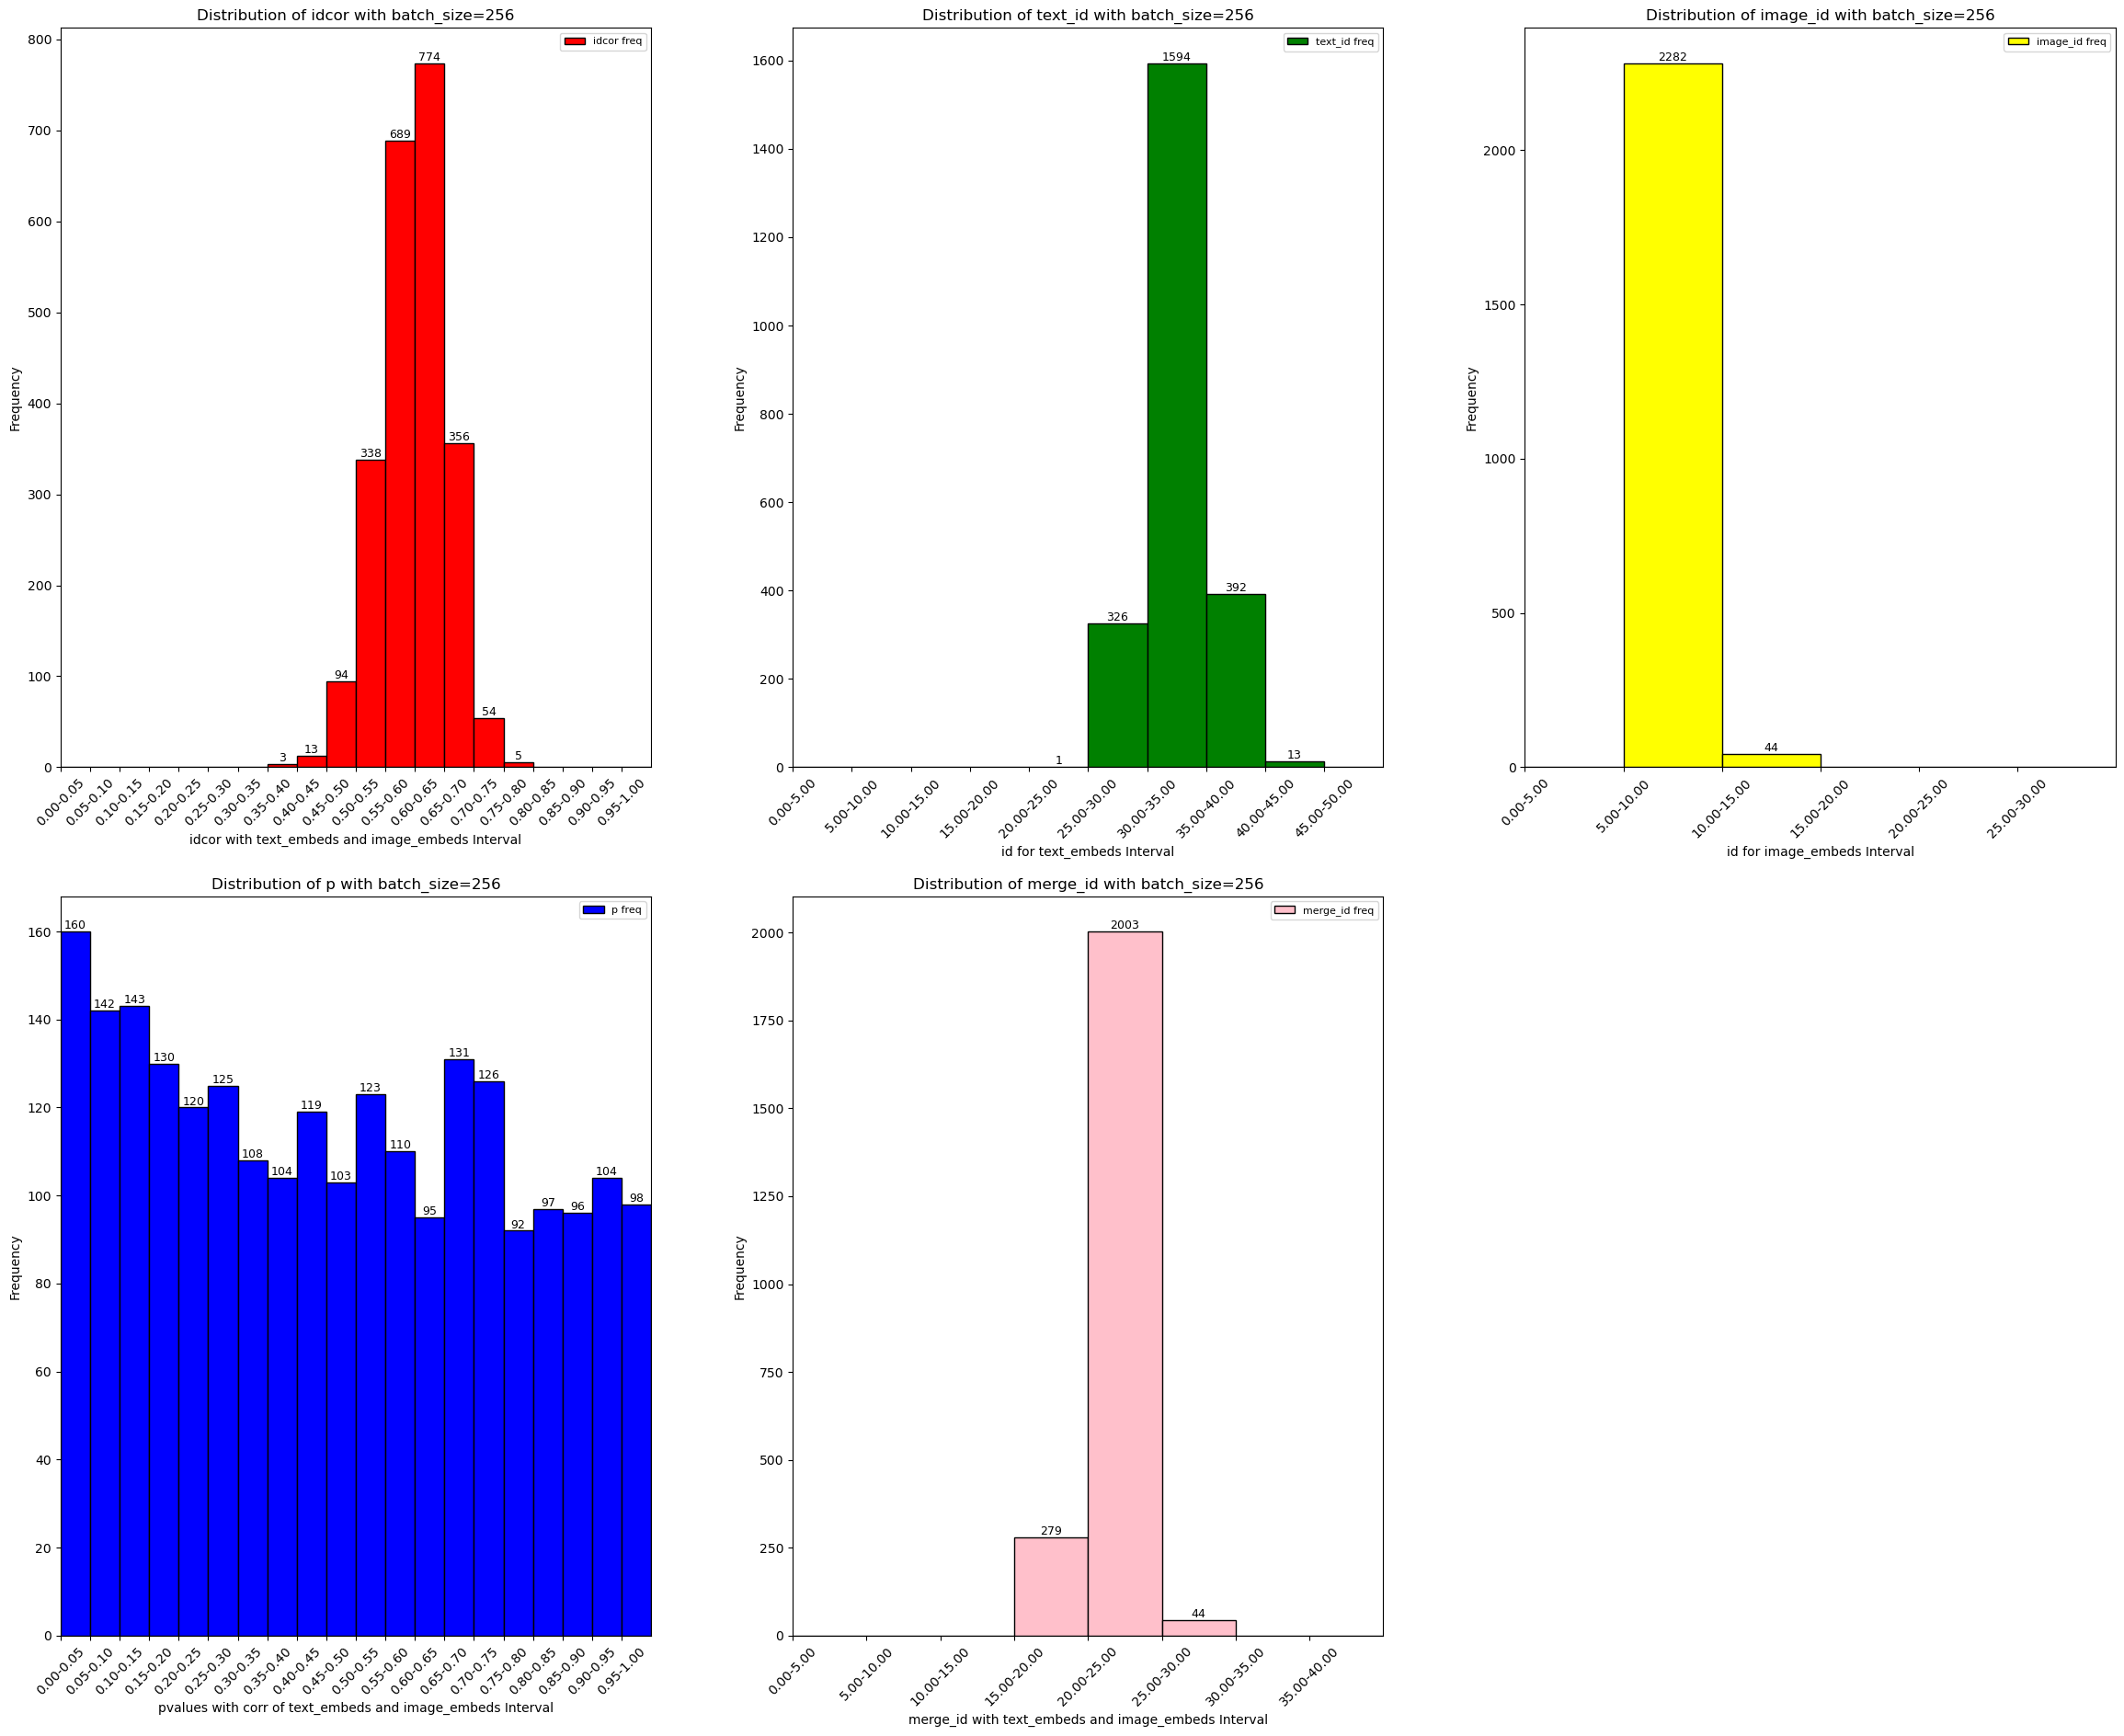

: 

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(25, 20))  # 创建一个包含 2 行 3 列子图的图形
fig.tight_layout(pad=8.0)  # 子图之间的间距

bin_start_list = [0.0, 0.0, 0.0, 0.0, 0.0]
bin_end_list = [1.0, 50.0, 30.0 ,1.0, 40.0]
bin_width_list = [0.05, 5.0, 5.0, 0.05, 5.0]
data_list = [idcor_list, text_id_list, image_id_list, p_list, merge_id_list]
name_list = ['idcor', 'text_id', 'image_id', 'p', 'merge_id']
color_list = ['red', 'green', 'yellow', 'blue', 'pink']
xlabel_list = [
    'idcor with text_embeds and image_embeds Interval',
    'id for text_embeds Interval',
    'id for image_embeds Interval',
    'pvalues with corr of text_embeds and image_embeds Interval',
    'merge_id with text_embeds and image_embeds Interval'
]

for i, ax in enumerate(axs.flat):  # axs.flat 会将二维子图展平，便于迭代
    if i < len(data_list):
        bins = np.arange(bin_start_list[i], bin_end_list[i] + bin_width_list[i], bin_width_list[i])  # 使用numpy的histogram函数来分割数据
        hist, bin_edges = np.histogram(data_list[i], bins=bins)
        
        # 绘制柱状图
        ax.bar(bin_edges[:-1], hist, width=bin_width_list[i], align='edge', edgecolor='black', color=color_list[i])
        
        # 设置标签
        ax.set_xlabel(xlabel_list[i])
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {name_list[i]} with batch_size={batch_size}')
        
        xScale = [f'{bin_edges[j]:.2f}-{bin_edges[j+1]:.2f}' for j in range(len(bin_edges)-1)]  # 设置x轴刻度
        ax.set_xticks(bin_edges[:-1])
        ax.set_xticklabels(xScale, rotation=45)  # 将标签旋转45度，防止重叠
        ax.set_xlim(bin_edges[0], bin_edges[-1])  # 设置x轴的范围
        
        # 在每个柱子上方显示频率数值
        for j in range(len(hist)):
            if hist[j] > 0:  # 只对频率大于0的柱子标识
                ax.text(bin_edges[j] + bin_width_list[i] / 2, hist[j], str(hist[j]), ha='center', va='bottom', fontsize=9, color='black')
        
        ax.legend([f'{name_list[i]} freq'], loc='upper right', fontsize=8)  # 添加图例

fig.delaxes(axs[1, 2])  # 删除右下角的空白子图
plt.show()